# Charging Network Enhancement Optimization Model

This notebook implements and solves the mixed-integer linear programming model for optimizing the Kitchener-Waterloo charging network enhancement through:

1. Model Implementation
   - Decision variable definition
   - Constraint formulation
   - Objective function development
   - Gurobi model construction

2. Scenario Analysis
   - Base case optimization
   - Budget sensitivity analysis
   - Coverage requirement variations
   - Phasing strategy options

3. Solution Analysis
   - Result visualization
   - Cost-benefit analysis 
   - Coverage improvement assessment
   - Implementation recommendations

In [1]:
# Setup and imports
import pandas as pd
import matplotlib.pyplot as plt
import json
import logging
from tabulate import tabulate

# Local imports 
from src.data.constants import *
from src.data.data_manager import DataManager
from src.model.network_optimizer import EVNetworkOptimizer
from src.data.utils import load_latest_file
from src.visualization.optimization_viz import *

# Configure logging
logging.getLogger('gurobipy').setLevel(logging.ERROR)
logging.getLogger('data_manager').setLevel(logging.ERROR)

# Initialize data manager
data_mgr = DataManager()

# Load configuration
config_path = PROJECT_ROOT / 'configs' / 'base.json'
with open(config_path) as f:
    base_config = json.load(f)

print("Setup complete!")

Setup complete!


## 1. Data Preparation and Model Setup
First, let's prepare our data and initialize the optimization model

In [2]:
# Prepare input data
print("🔄 Preparing optimization data...")
input_data = data_mgr.prepare_optimization_data()

🔄 Preparing optimization data...

📊 Preparing Optimization Model Data

🔄 OPT-PREP-STEP 1.1: LOADING BASE DATA...


1️⃣ Region of Waterloo Census Data:
----------------------------------------
    📊 Regional Summary:
    ------------------------------------
    Total Population: 637,730
    Total Area: 2487.2 km²
    Average Regional Density: 256.4 people/km²

2️⃣ Statistics Canada Data:
----------------------------------------
Population Estimate: 575,847

3️⃣ UN Population Data:
----------------------------------------
Population Estimate: 622,497

📊 Source Comparison Summary:
--------------------------------------------------
Region of Waterloo: 637,730
Statistics Canada: 575,847
UN Data: 622,497

Confidence Score: 0.94

📊 OPT-PREP-STEP 1.2: LOADING CHARGING STATIONS...

Fetching Charging Stations...
📡 Retrieved 240 stations from API

📊 Charging Station Summary:
--------------------------------------------------
Total API Results: 240
Successfully Processed: 240
Skipped Records: 0
Wi

INFO:src.data.data_manager:Total population: 637,730
INFO:src.data.data_manager:Covered population: 637,040
INFO:src.data.data_manager:Total population: 637,730
INFO:src.data.data_manager:Covered population: 485,640


✓ Processed 7705 potential sites!


📏 OPT-PREP-STEP 4: CALCULATING DISTANCE MATRICES...


Site-to-Demand Distance: 100%|██████████| 7705/7705 [00:30<00:00, 256.30it/s]


Matrix Dimensions:
- Distance matrix: (7705, 379)
- Number of stations: 183
- Number of demand points: 379
- Number of potential sites: 7705

Distance Statistics:
- Mean distance: 8.26 km
- Max distance: 44.09 km
- Min distance: 0.00 km

Theoretical Coverage Possible (with unlimited budget):
- L2 coverage possible: 95.51%
- L3 coverage possible: 98.42%


In [3]:
# Initialize optimizer
print("\n🤖 Initializing optimizer...")
optimizer = EVNetworkOptimizer(input_data, base_config)


🤖 Initializing optimizer...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2589656
Academic license 2589656 - for non-commercial use only - registered to ja___@uwaterloo.ca


In [4]:
# Get program documentation
print("\n📝 Getting model documentation...")
program_doc = optimizer.get_program_documentation()

def make_header(text: str, char: str, length: int = 70) -> str:
    """Create a header with a given character."""
    return f"\n{char*length}\n{text:^{length}}\n{char*length}"

def format_program_documentation(doc: Dict[str, Any]) -> str:
    """Format program documentation into human-readable text."""
    summary = []
    summary.append(make_header("EV Charging Network Enhancement Optimization Program".upper(), '='))
    
    # Data Summary
    summary.append(make_header("1. DATA SUMMARY", "-"))
    summary.append(f"\n- Demand Points: {doc['data_summary']['demand_points']}")
    summary.append(f"\n - Existing Stations:")
    summary.append(f"    - Total: {doc['data_summary']['existing_stations']['total']}")
    summary.append(f"    - L2: {doc['data_summary']['existing_stations']['l2_stations']}")
    summary.append(f"    - L3: {doc['data_summary']['existing_stations']['l3_stations']}")
    summary.append(f"\n - Potential Sites: {doc['data_summary']['potential_sites']}")
    
    # Decision Variables
    summary.append(make_header("2. DECISION VARIABLES", "-"))
    for var_name, var_info in doc['decision_variables'].items():
        summary.append(f"\n - {var_name}:")
        summary.append(f"    - Type: {var_info['type']}")
        summary.append(f"    - Size: {var_info['dimension']}")
        if 'bounds' in var_info:
            summary.append(f"    - Bounds: {var_info['bounds']}")
        summary.append(f"    - Description: {var_info['description']}")
    
    # Constraints
    summary.append(make_header("3. CONSTRAINTS", "-"))
    summary.append(f"\n - Budget: ${doc['constraints']['budget']['bound']:,.2f}")
    summary.append(f"\n -  Coverage Requirements:")
    summary.append(f"    - L2: {doc['constraints']['coverage']['l2_coverage']['bound']*100}% within {doc['parameters']['coverage_radii']['l2_radius']}km")
    summary.append(f"    - L3: {doc['constraints']['coverage']['l3_coverage']['bound']*100}% within {doc['parameters']['coverage_radii']['l3_radius']}km")
    summary.append(f"\n - Infrastructure:")
    summary.append(f"    - Grid Capacity: {doc['constraints']['infrastructure']['grid_capacity']['bound']} kW")
    summary.append(f"    - Minimum L3 Ports: {doc['constraints']['infrastructure']['min_l3_ports']['bound']}")
    summary.append(f"\n - Logical Constraints:")
    for constraint in doc['constraints']['logical']:
        summary.append(f"    - {constraint}")
    
    # Objective Function
    summary.append(make_header("4. OBJECTIVE FUNCTION", "-"))
    summary.append("\nMaximize:")
    for component, info in doc['objective']['components'].items():
        summary.append(f"  {info['weight']} * {info['description']}")
    
    return '\n'.join(summary).join(['\n', '\n'])

# Print out program documentation
print(format_program_documentation(program_doc))


📝 Getting model documentation...


         EV CHARGING NETWORK ENHANCEMENT OPTIMIZATION PROGRAM         

----------------------------------------------------------------------
                           1. DATA SUMMARY                            
----------------------------------------------------------------------

- Demand Points: 379

 - Existing Stations:
    - Total: 183
    - L2: 167
    - L3: 16

 - Potential Sites: 7705

----------------------------------------------------------------------
                        2. DECISION VARIABLES                         
----------------------------------------------------------------------

 - new_l2_stations:
    - Type: Binary
    - Size: 7705
    - Description: 1 if new L2 station placed at site i, 0 otherwise

 - new_l3_stations:
    - Type: Binary
    - Size: 7705
    - Description: 1 if new L3 station placed at site i, 0 otherwise

 - upgrades:
    - Type: Binary
    - Size: 7705
    - Description: 1 if L2 station at site i is 

## 2. Base Case Optimization
Now let's run our base case optimization and analyze the results:

In [5]:
# Run optimization
print("✨ Running base case optimization...")
solution = optimizer.optimize()

✨ Running base case optimization...

1. Setting up optimization model...
✓ Model parameters configured
✓ Decision variables created
✓ Constraints added
✓ Objective function set

2. Starting optimization...

3. Processing optimal solution...
✓ Found 10 upgrades
✓ Found 32 new L2 stations and 7 new L3 stations
✓ Processed 32 L2 ports and 17 L3 ports

4. Creating solution structure...
✓ Station statuses updated
✓ Solution creation complete!


In [6]:
if solution['status'] == 'optimal':
    print("\n✅ Optimization successful!")
    
    # Print summary statistics
    print("\nCoverage Improvements:")
    print("-" * 30)
    initial_l2 = solution['coverage']['initial']['l2_coverage'] * 100
    final_l2 = solution['coverage']['final']['l2_coverage'] * 100
    initial_l3 = solution['coverage']['initial']['l3_coverage'] * 100
    final_l3 = solution['coverage']['final']['l3_coverage'] * 100
    
    print(f"L2 Coverage: {initial_l2:.1f}% → {final_l2:.1f}%")
    print(f"L3 Coverage: {initial_l3:.1f}% → {final_l3:.1f}%")
    
    # Create solution visualization
    print("\n📊 Creating solution visualizations...")
    stations_df = load_latest_file(DATA_PATHS['charging_stations'])
    
    # Plot optimization results
    fig = plot_optimization_results(solution, save_path=None)
    plt.show()
    
    # Create coverage map
    m = create_results_map(solution, base_config)
    draw_map(m)
else:
    print(f"❌ Optimization failed: {solution.get('message', 'Unknown error')}")


✅ Optimization successful!

Coverage Improvements:
------------------------------
L2 Coverage: 14.6% → 95.6%
L3 Coverage: 1.8% → 88.2%

📊 Creating solution visualizations...


## 3. Sensitivity Analysis
Let's analyze how our solution changes with different parameters:

In [7]:
# Run sensitivity analysis
print(make_header("Sensitivity Analysis Results", "="))
sensitivity_results = optimizer.perform_sensitivity_analysis()

# Format and display insights
print("\nKey Insights:")
print("-" * 50)
for i, insight in enumerate(sensitivity_results['insights'], 1):
    print(f"{i}. {insight}")

# Create constraint analysis table
print("\nConstraint Analysis:")
print("-" * 50)
headers = ["Constraint", "Required", "Achieved", "Utilization"]
constraint_data = []

for name, values in sensitivity_results['constraints'].items():
    rhs = values['rhs']
    achieved = rhs - values['slack']
    utilization = values['utilization']
    
    if 'Budget' in name:
        required = f"${rhs:,.2f}"
        achieved = f"${achieved:,.2f}"
    else:
        required = f"{rhs*100:.1f}%"
        achieved = f"{(rhs - values['slack'])*100:.1f}%"
    
    constraint_data.append([
        name,
        required,
        achieved,
        f"{utilization:.1f}%"
    ])

print(tabulate(constraint_data, headers=headers, tablefmt="grid"))


                     Sensitivity Analysis Results                     

Key Insights:
--------------------------------------------------
1. Budget constraint is binding - additional funding of $4,000,000.00 could improve the solution
2. L2 Coverage: Achieved 100.6% coverage (required 95.0%)
3. L3 Coverage: Achieved 103.7% coverage (required 85.0%)

Constraint Analysis:
--------------------------------------------------
+--------------+---------------+---------------+---------------+
| Constraint   | Required      | Achieved      | Utilization   |
+==============+===============+===============+===============+
| Budget       | $4,000,000.00 | $4,000,000.00 | 100.0%        |
+--------------+---------------+---------------+---------------+
| L2 Coverage  | 95.0%         | 95.6%         | 100.6%        |
+--------------+---------------+---------------+---------------+
| L3 Coverage  | 85.0%         | 88.2%         | 103.7%        |
+--------------+---------------+---------------+--------

In [8]:
# Create visualization
sens_fig = plot_sensitivity_results(sensitivity_results)
plt.show()

# Add further analysis if budget is binding
if 'Budget' in sensitivity_results['constraints']:
    budget_data = sensitivity_results['constraints']['Budget']
    if budget_data['slack'] < 1e-6:
        print("\nBudget Impact Analysis:")
        print("-" * 50)
        print("• Budget constraint is binding - consider these options:")
        print("  1. Seek additional funding")
        print("  2. Phase implementation to spread costs")
        print("  3. Prioritize high-impact locations first")


Budget Impact Analysis:
--------------------------------------------------
• Budget constraint is binding - consider these options:
  1. Seek additional funding
  2. Phase implementation to spread costs
  3. Prioritize high-impact locations first


## 4. Implementation Planning
Based on our optimization results, let's develop a phased implementation plan:

In [9]:
# Create and display implementation plan
implementation_plan = optimizer.get_implementation_plan(solution)


                         IMPLEMENTATION PLAN                          

----------------------------------------------------------------------
                            Phase Details                             
----------------------------------------------------------------------
Phase 1: L2 to L3 Upgrades
   • Convert existing L2 stations to L3
   • Install new L3 ports
   • Upgrade electrical infrastructure

Phase 2: New L3 Stations
   • Install new L3 stations
   • Add L3 charging ports
   • Implement grid connections

Phase 3: New L2 Network
   • Install new L2 stations
   • Add L2 charging ports
   • Complete network coverage

----------------------------------------------------------------------
                       Detailed Phase Analysis                        
----------------------------------------------------------------------
+---------+-----------+---------------------+---------------+------------------+
|  Phase  |  Actions  |  Stations Modified  |  Ports Added  |

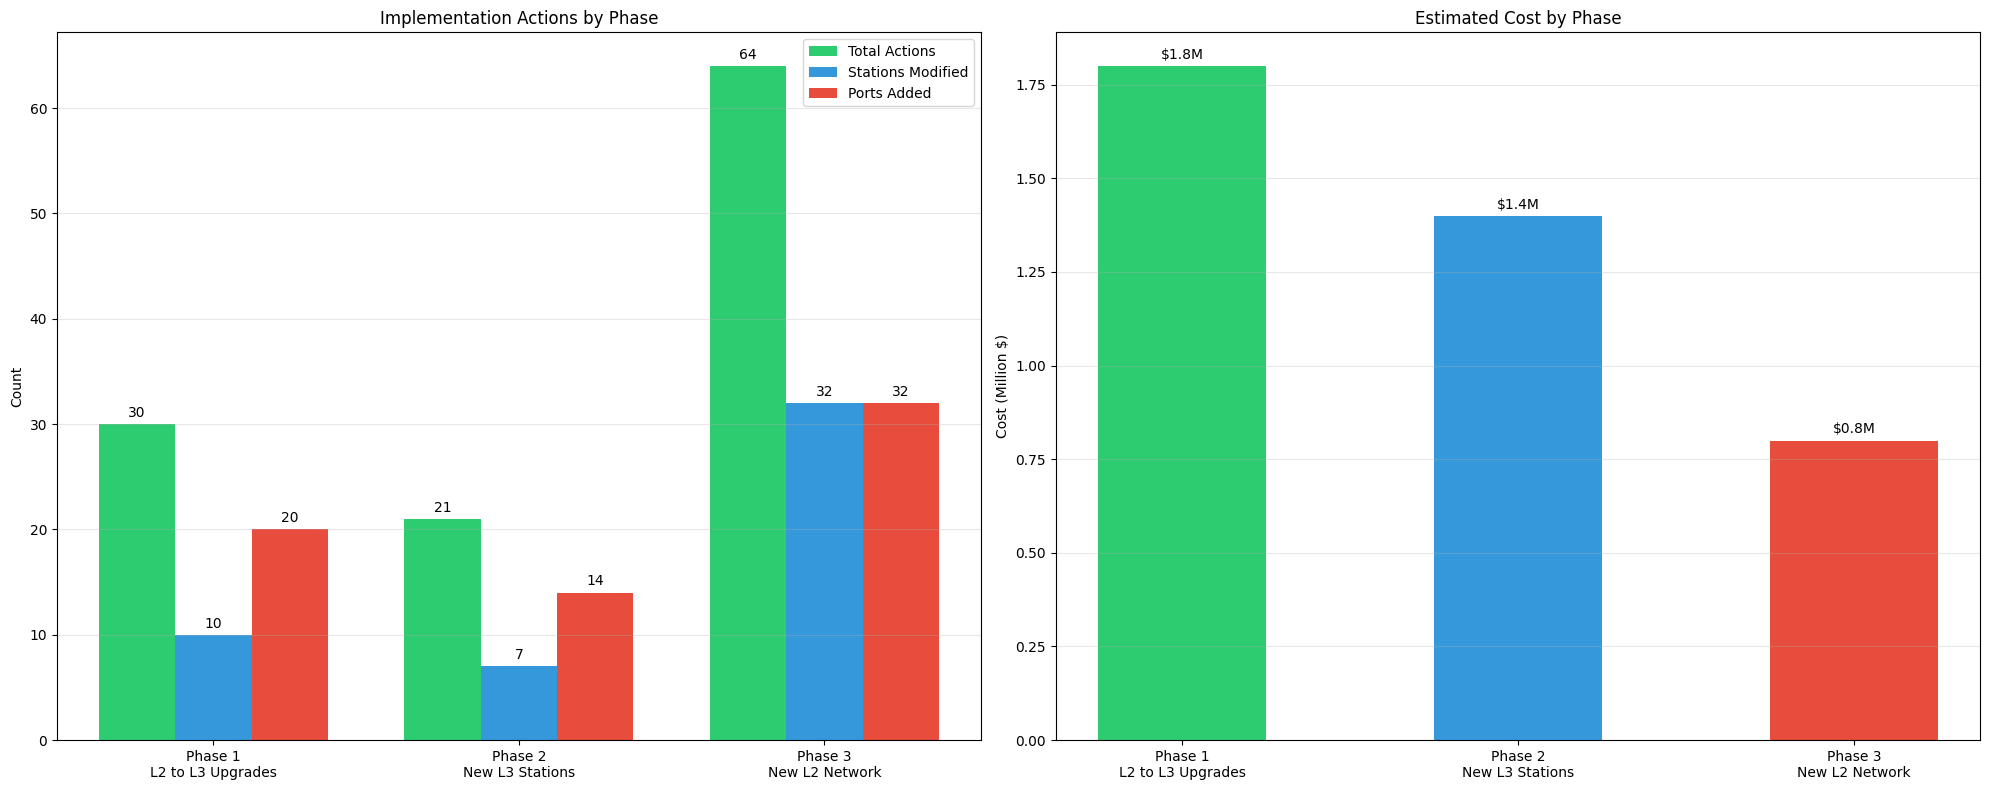

In [10]:
plot_implementation_plan(implementation_plan)

## 5. Recommendations and Next Steps

Based on our analysis, here are the key recommendations for implementation:

1. Phase 1 (Months 1-4):
   - Focus on L3 upgrades
   - Target high-traffic areas first
   - Verify grid capacity at upgrade locations

2. Phase 2 (Months 5-8):
   - Deploy new L3 stations
   - Coordinate with utility providers
   - Begin site preparation work

3. Phase 3 (Months 9-12):
   - Complete L2 network expansion
   - Monitor usage patterns
   - Adjust port allocations based on demand

Key considerations for successful implementation:
- Coordinate with utility providers early
- Develop contingency plans for construction delays
- Monitor actual usage patterns to validate model assumptions
- Consider weather impacts on construction timeline